# MARL Training

We are trying to minimize the cost of energy, while keeping the throughput the same, ensuring that product requests are down before their deadline.

Agents: Each Machine
Environment: Factory
State/Observation: The feasible and non feasible Actions

In [ ]:
%pip install tensorboard
%pip install stable-baselines3
%pip install stable-baselines3[extra]
%pip install pytorch
%pip install gymnasium
%pip install ipywidgets

## Load Env

In [1]:
import sys
from pathlib import Path

# Add project root to Python path
project_root = Path().resolve().parent.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

project_root

WindowsPath('C:/Users/weinbendera/MSOE_Classes/Theory_of_Machine_Learning/Production Line Final/Production-Line-CSC4601')

In [2]:
import json

from factory.factory_schemas import ProductRequest
from factory.job_builder import JobBuilder
from factory.factory_logic_loader import FactoryLogicLoader
from factory.factory import Factory

steps = 1152

data_file = project_root / "data" / "Input_JSON_Schedule_Optimization.json"
with open(data_file, 'r', encoding='utf-8') as f:
    data = json.load(f)

product_requests_data = data["product_requests"]
product_requests = [ProductRequest(**pr) for pr in product_requests_data]

factory_logic = FactoryLogicLoader.load_from_file(filepath=str(data_file))
job_builder = JobBuilder(factory_logic=factory_logic)
jobs = job_builder.build_jobs(product_requests=product_requests)

factory = Factory(factory_logic=factory_logic)
factory.add_jobs(jobs=jobs)
product_requests

[ProductRequest(product='WOVEN LABEL OURELA FABRIC', amount=13, deadline=None),
 ProductRequest(product='ESTORE RIBBON', amount=6, deadline=None),
 ProductRequest(product='WOVEN LABEL OURELA CUT', amount=5, deadline=None),
 ProductRequest(product='GORGORÃO RIBBON', amount=13, deadline=None),
 ProductRequest(product='GORGORÃO RIBBON W/ INSCR', amount=5, deadline=None),
 ProductRequest(product='TAFFETA EMBLEM', amount=10, deadline=None),
 ProductRequest(product='PRINTED RIBBON', amount=30, deadline=None),
 ProductRequest(product='ELASTIC W/ INSCR', amount=2, deadline=None),
 ProductRequest(product='ELASTIC W/ INSCR', amount=1, deadline=960),
 ProductRequest(product='ROK ELASTIC', amount=3, deadline=None),
 ProductRequest(product='SMOOTH STRAP(A)', amount=4, deadline=None),
 ProductRequest(product='BRAIDED ELASTIC', amount=15, deadline=None),
 ProductRequest(product='PRINTED RIBBON  PES', amount=10, deadline=None),
 ProductRequest(product='SMOOTH ELASTIC(A)', amount=5, deadline=None),
 Pr

## Test IPPO Agents

Loaded agent for MAQ118
Loaded agent for MAQ119
Loaded agent for MAQ120
Energy Cost Total: 56.72912765000002
Number of jobs not done: 1
Number of jobs done: 131


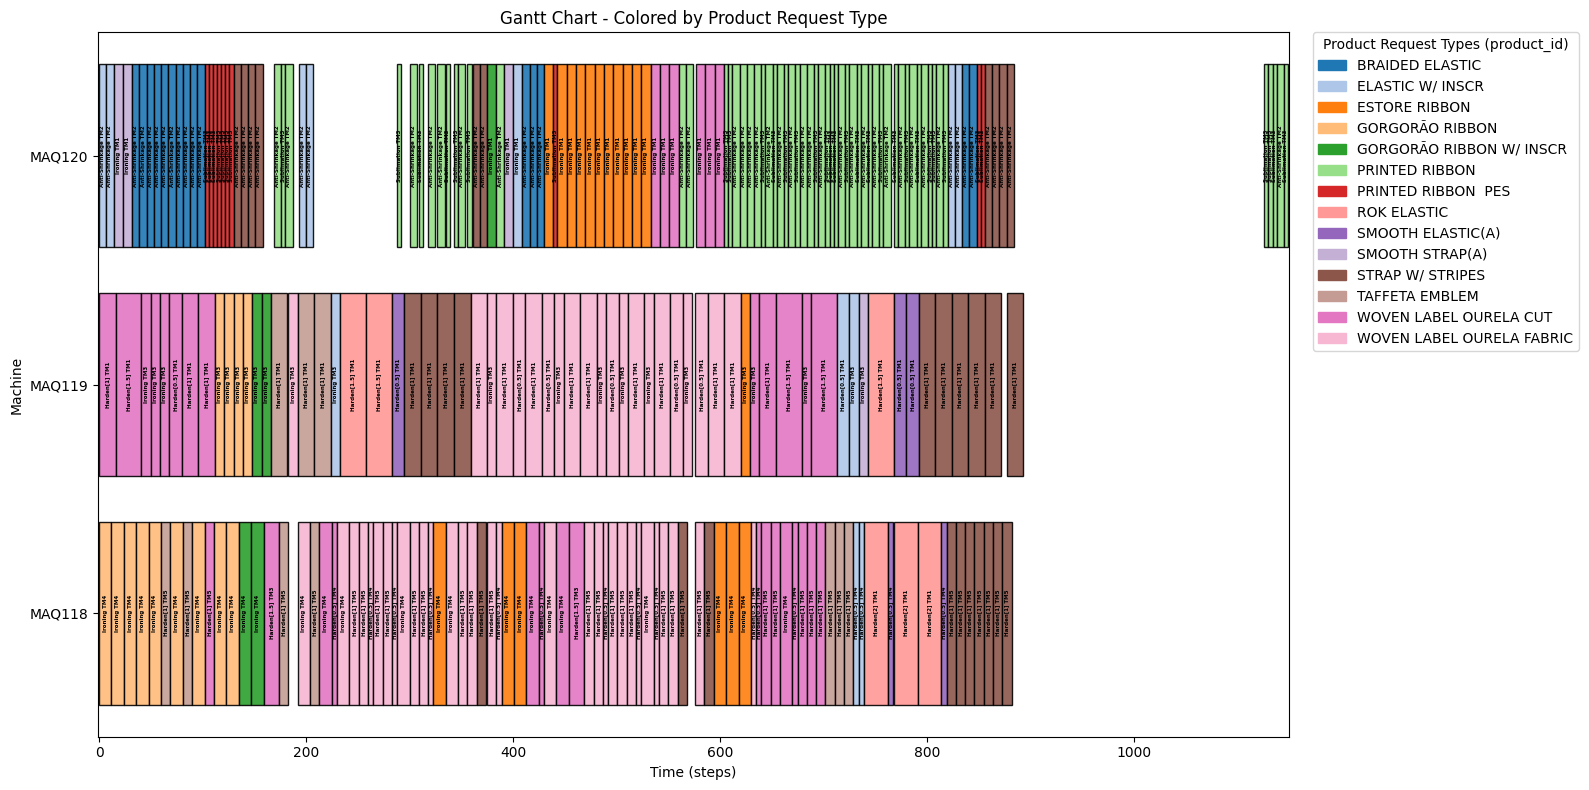

In [3]:
from schedulers.marl.marl_scheduler import MARLScheduler

state = factory.get_factory_state()

# calculate max number of feasible actions
# during training and evaluation, RL Agents must have same actionspace (max feasible actions)
max_feasible_actions = max(
    len(state.get_feasible_actions(machine_id)) 
    for machine_id in state.machine_ids
)
max_feasible_actions = int(max_feasible_actions * 1.2)
max_feasible_actions = max(10, max_feasible_actions)

# choose the scheduler
scheduler = MARLScheduler.load_from_directory(
    model_dir="models/marl_independent",
    max_feasible_actions=max_feasible_actions,
    max_steps=steps
)

total_power_cost = 0
while not factory.done() and factory.current_step < steps:
    chosen_actions = scheduler.choose(state)
    factory.apply_actions(chosen_actions)
    step_info = factory.step()
    total_power_cost += step_info['step_power_cost']
    state = factory.get_factory_state()

print(f"Energy Cost Total: {total_power_cost}")
print(f"Number of jobs not done: {len([job for job in factory.jobs if not job.done])}")
print(f"Number of jobs done: {len([job for job in factory.jobs if job.done])}")

scheduled_actions = scheduler.scheduled_actions
# remove None objects
scheduled_actions = [
    action for action in scheduled_actions
    if action is not None
]

scheduler.plot_gantt_by_product(factory, scheduled_actions)